In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0)]


# Process Data

In [6]:
# Read in file
d_df = pd.read_csv('../data/IRD/deaths.csv')
# Drop China and Diamond Princess
for c in ['China', 'Diamond Princess']:
    d_df = d_df[d_df['Country/Region']!=c]
d_df['Country/Region'].iloc[~d_df['Province/State'].isnull().values] += ' / '+d_df['Province/State']
d_df = d_df.drop(columns=['Province/State', 'Lat', 'Long'])
d_df.set_index(keys='Country/Region', inplace=True)
# Drop low deaths
d_df = d_df[(d_df.max(axis=1)>20)]

In [29]:
deaths = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>3000), axis=1)
for i, country in enumerate(d_df.index):
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            deaths[country] = d_df.T[country].values[start_days[i]:end_days[i]]
        else:
#             print('hello')
            deaths[country] = d_df.T[country].values[start_days[i]:]

In [30]:
len(deaths)

78

In [38]:
with open('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 'w') as fp:
    for c in deaths:
        fp.write(c+'|\n')

# Bayesian Model

In [11]:
# def sigmoid(a, t0, t):
#     return 1.0/(1.0+np.exp(-a*(t-t0)))

In [12]:
# def step_inter(Di, GR0, GR1, a, t0, t):
#     D = [Di,]
#     for i in range(1, len(t)):
#         step = sigmoid(a, t0, t[i])
#         D.append(D[i-1]*(GR0*(1-step)+GR1*step))
#     return np.array(D)

In [13]:
def step_inter(Di, GR0, GR1, t0, t):
    
    step = np.heaviside(t[1:]-t0, 0)
    D = np.concatenate([np.array([Di]), np.exp(np.cumsum(np.log(GR0*(1-step)+GR1*step)))])
    
    return D

In [14]:
def model():
    
    N = len(deaths)
    
    Di = numpyro.sample('Di', dist.Normal(7.0*np.ones(N), 3.0*np.ones(N)))
    GR1 = numpyro.sample('GR1', dist.Normal(1.33*np.ones(N), 0.5*np.ones(N)))
    GR2 = numpyro.sample('GR2', dist.Normal(1.2*np.ones(N), 0.5*np.ones(N)))
    t0 = numpyro.sample('t0', dist.Normal(15*np.ones(N), 5*np.ones(N)))
#     Decay = numpyro.sample('Decay', dist.Normal(1.0*np.ones(N), 0.5*np.ones(N)))
    
    # Create likelihood for each country    
    for i, country in enumerate(deaths):
        dead = deaths[country]
        t = np.arange(len(dead))
        prediction = step_inter(Di[i], GR1[i], GR2[i], t0[i], t)
#         prediction = step_inter(Di[i], GR1[i], GR2[i], Decay[i], t0[i], t)
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [15]:
N = len(deaths)

init_params = {'Di': 7.0*np.ones((N_chains, N)),
               'GR1': 1.33*np.ones((N_chains, N)),
               'GR2': 1.2*np.ones((N_chains, N)),
               't0': 15.0*np.ones((N_chains, N)),
#                'Decay': 1.0*np.ones((N_chains, N)),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [16]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

sample: 100%|██████████| 1500/1500 [27:34<00:00,  1.10s/it, 447 steps of size 2.33e-03. acc. prob=0.65] 


Time taken to compile model and draw samples : 1688.736302614212 s


In [22]:
tc = np.mean(-np.log((1./p)-1)/samples['Decay'] + samples['t0'], axis=0)

NameError: name 'p' is not defined

In [26]:
np.mean(samples['t0'], axis=0)

DeviceArray([14.582589, 15.403359, 15.4792  , 14.481578, 15.472376,
             15.462967, 15.256238], dtype=float32)

In [17]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.0.3_STEP_EXP_Independent_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     Di[0]      6.12      0.69      6.10      5.09      7.29     11.33      1.00
     Di[1]      5.68      1.31      5.46      3.97      7.87      3.03      2.03
     Di[2]      7.21      0.94      7.56      5.49      8.26      3.00      1.93
     Di[3]      6.61      1.94      6.03      4.08     10.24      4.87      1.15
     Di[4]      5.61      0.68      5.78      4.37      6.47     11.10      1.24
     Di[5]      6.37      0.75      6.29      5.37      7.74      4.76      1.37
     Di[6]      7.72      0.51      7.71      7.03      8.60      4.05      1.79
    GR1[0]      1.47      0.00      1.47      1.47      1.48    268.39      1.00
    GR1[1]      1.47      0.00      1.47      1.47      1.47    607.60      1.00
    GR1[2]      1.55      0.00      1.55      1.55      1.56    286.97      1.00
    GR1[3]      1.24      0.00      1.24      1.23      1.25    202.00      1.00
    GR1[4]      1.33      0

In [18]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.3_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [19]:
for a in zip(deaths, zip(np.mean(samples['GR1'], axis=0), np.mean(samples['GR2'], axis=0))):
    print(a)

('France', (1.4717374, 1.2385337))
('Iran', (1.4676784, 1.1052543))
('Italy', (1.5522369, 1.1919721))
('Japan', (1.2395018, 1.0580611))
('Korea, South', (1.3265461, 1.0350199))
('Spain', (1.6547923, 1.1137854))
('US', (1.3804842, 1.280996))


In [23]:
import json

In [24]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json'))

Text(0, 0.5, 'Growth Rate [per day]')

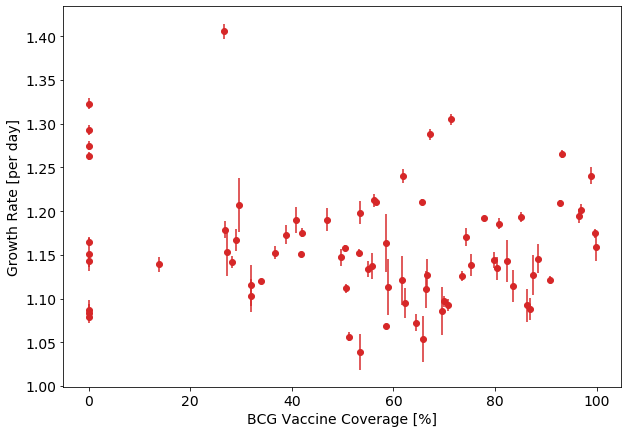

In [37]:
plt.figure(figsize=(10,7))
for i, c in enumerate(bcg_countries+nonbcg_countries+other):
    try:
        plt.errorbar(bcg_cov_est[c], np.mean(samples['GR'][:,i]), 
                     yerr=np.std(samples['GR'][:,i]), color='tab:red', fmt='o')
    except:
        continue
plt.xlabel('BCG Vaccine Coverage [%]')
plt.ylabel('Growth Rate [per day]')

In [38]:
deaths

{'Afghanistan': array([ 4,  4,  4,  4,  4,  4,  4,  6,  6,  7,  7, 11, 14, 14, 15, 15, 18,
        18, 21, 23, 25]),
 'Albania': array([ 4,  5,  5,  6,  8, 10, 10, 11, 15, 15, 16, 17, 20, 20, 21, 22, 22,
        23, 23, 23, 23, 23, 24, 25]),
 'Algeria': array([  4,   4,   4,   7,   9,  11,  15,  17,  17,  19,  21,  25,  26,
         29,  31,  35,  44,  58,  86, 105, 130, 152, 173, 193, 205, 235,
        256, 275, 293, 313, 326, 336]),
 'Andorra': array([ 6,  8, 12, 14, 15, 16, 17, 18, 21, 22, 23, 25, 26, 26, 29, 29, 31,
        33]),
 'Argentina': array([  4,   4,   4,   6,   8,   9,  13,  18,  19,  23,  27,  28,  36,
         39,  43,  44,  48,  56,  63,  72,  82,  83,  90,  97, 102, 111]),
 'Armenia': array([ 4,  7,  7,  7,  7,  8,  8,  9, 10, 12, 13, 13, 14, 16, 17]),
 'Australia / New South Wales': array([ 4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9, 10,
        12, 12, 16, 18, 21, 21, 21, 22, 23, 24, 25, 25, 25]),
 'Australia / Victoria': array([ 4,  4,  4,  4,  

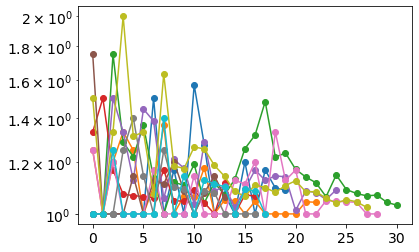

In [55]:
n = 1
for i, c in enumerate(deaths):
    if i==10:
        break
    plt.semilogy((deaths[c][:-n]/deaths[c][n:])**(-1/n), 'o-')

# Example Plots

TypeError: Cannot concatenate arrays with different ranks, got 2, 1.

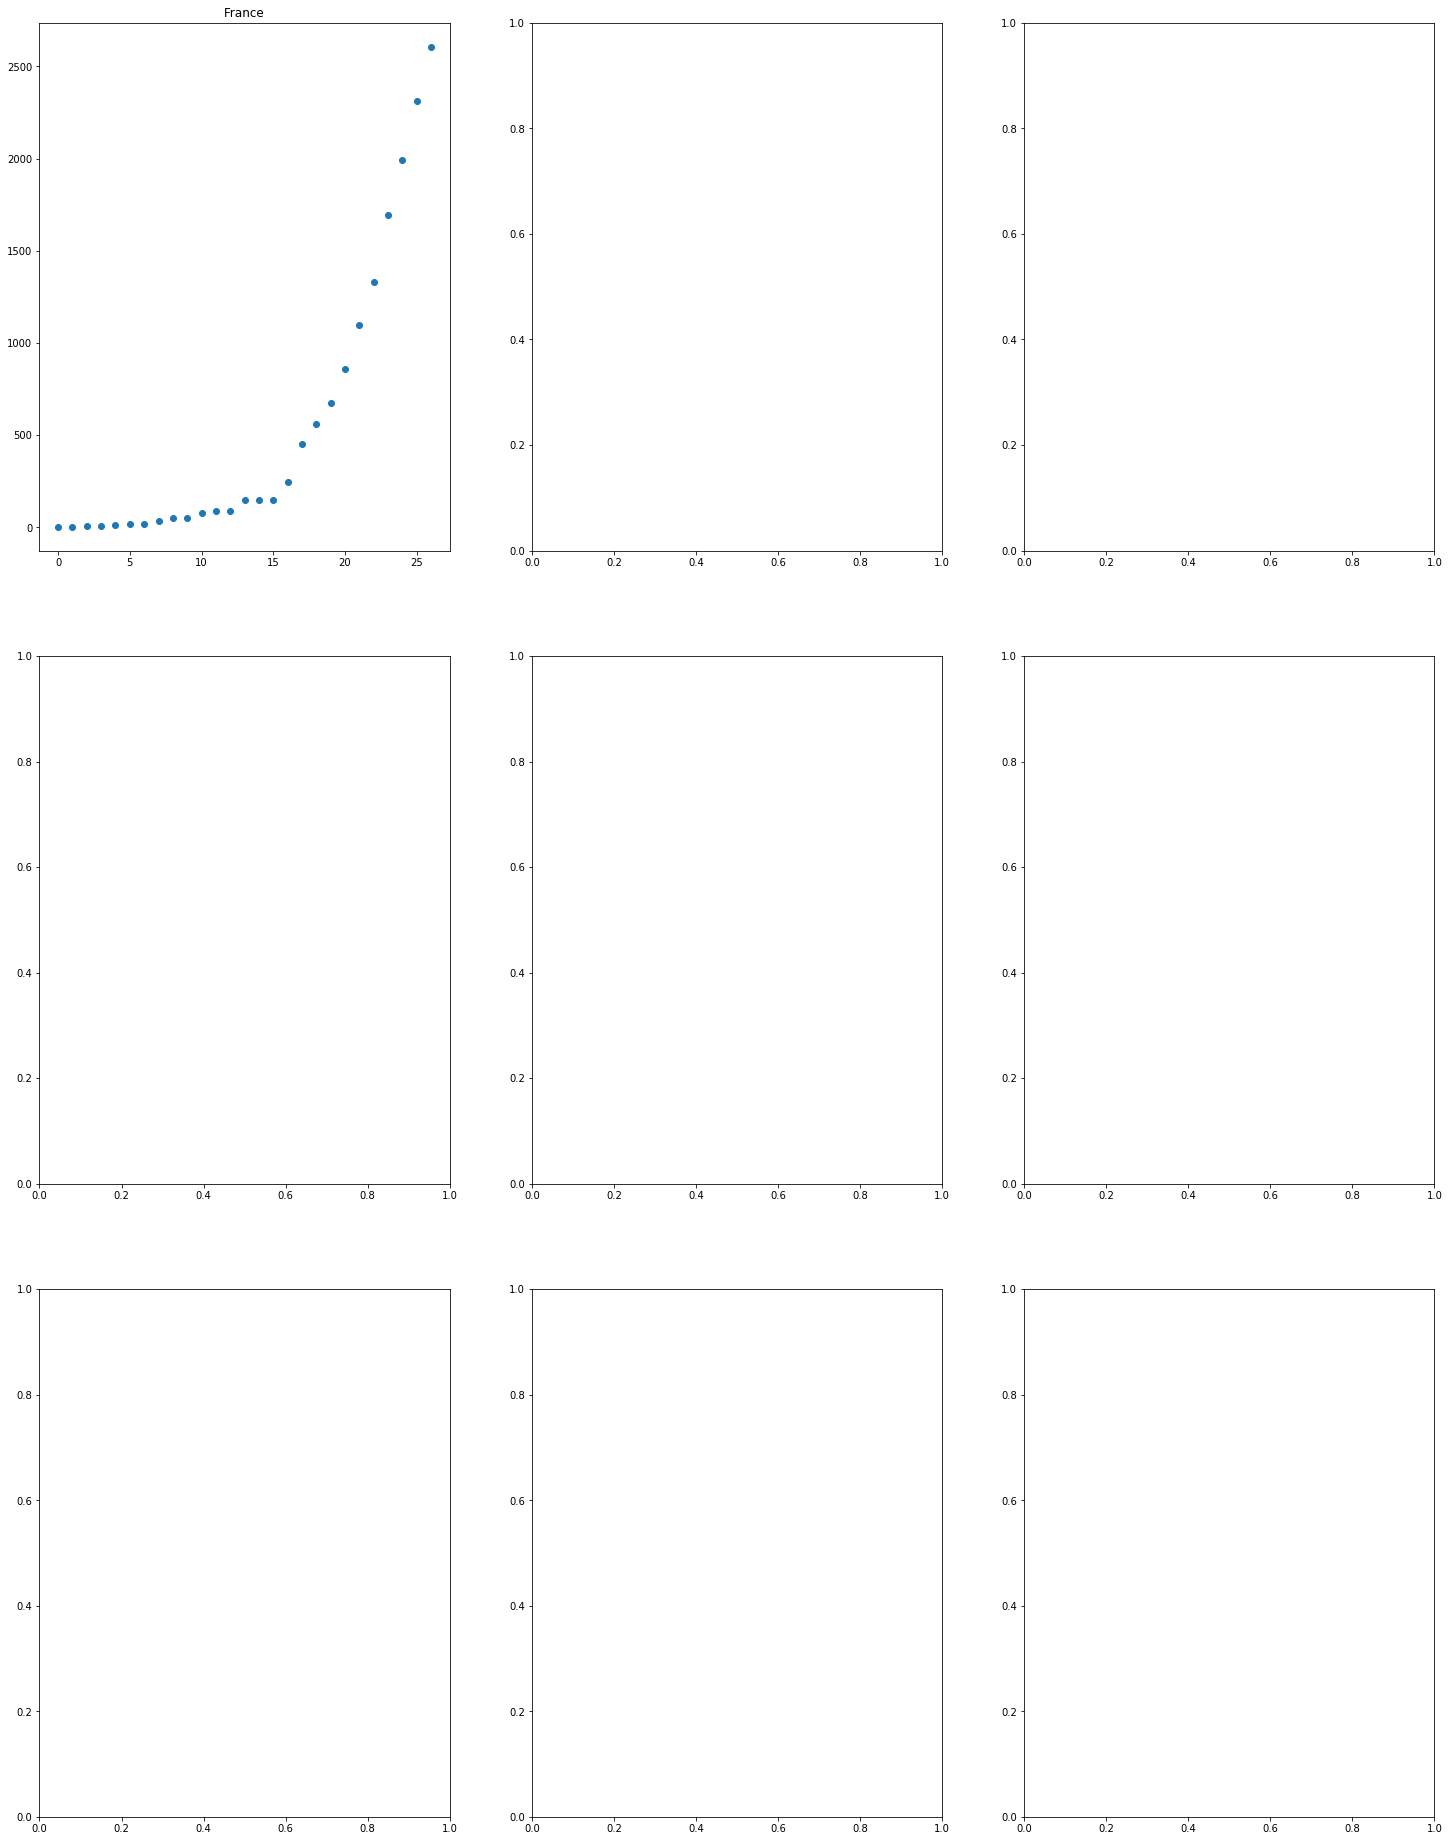

In [20]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(3, 3, figsize=(fig_scale*25,fig_scale*33))
a = ax.flatten()
for i, c in enumerate(deaths):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].plot(deaths[c], 'o')
    a[i].semilogy(np.mean(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                                     samples['GR2'][::10,i].T, 
                                     samples['t0'][::10,i].T, t[:,None]), axis=1), 'g', alpha=1)
    a[i].plot(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                         samples['GR2'][::10,i].T, 
                         samples['t0'][::10,i].T, t[:,None]), 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1.0_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

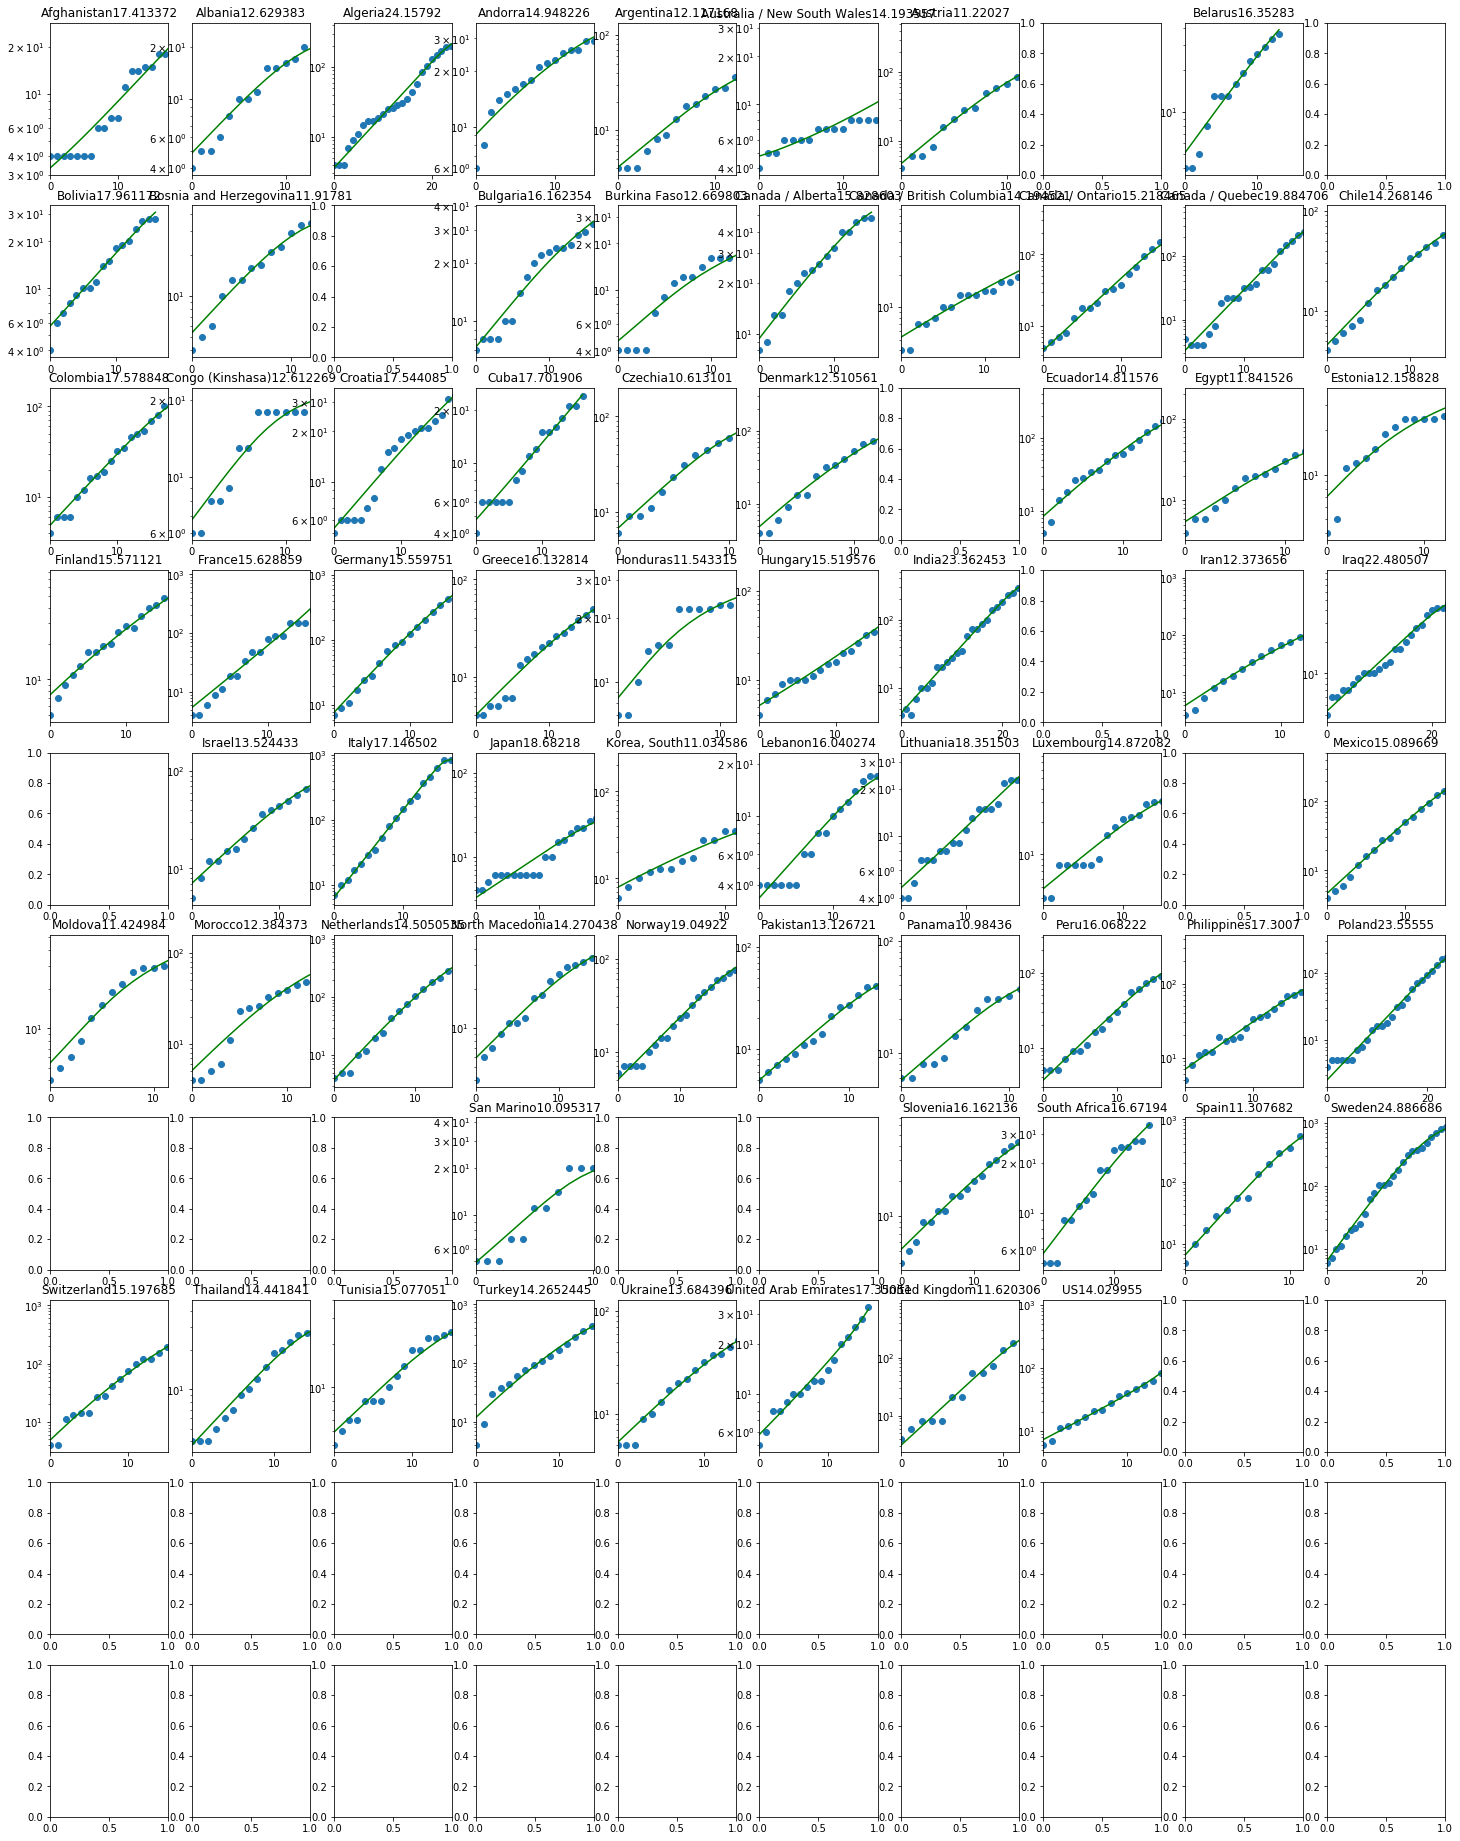

In [82]:
p = 0.5
tc = np.mean(-np.log((1./p)-1)/samples['Decay'] + samples['t0'], axis=0)

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(10, 10, figsize=(fig_scale*25,fig_scale*33))
a = ax.flatten()
for i, c in enumerate(deaths):
    if tc[i] < 10:
        continue
    t = np.arange(len(deaths[c]))
    a[i].set_title(c+str(tc[i]))
    a[i].plot(deaths[c], 'o')
    a[i].semilogy(np.mean(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                                     samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                                     samples['t0'][::10,i].T, t[:,None]), axis=1), 'g', alpha=1)
#     a[i].plot(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
#                          samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
#                          samples['t0'][::10,i].T, t[:,None]), 'r', alpha=0.01)
    
    a[i].set_xlim(0, tc[i] if tc[i]>0 else len(deaths[c]))
# plt.savefig('../plots/4.1.0_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

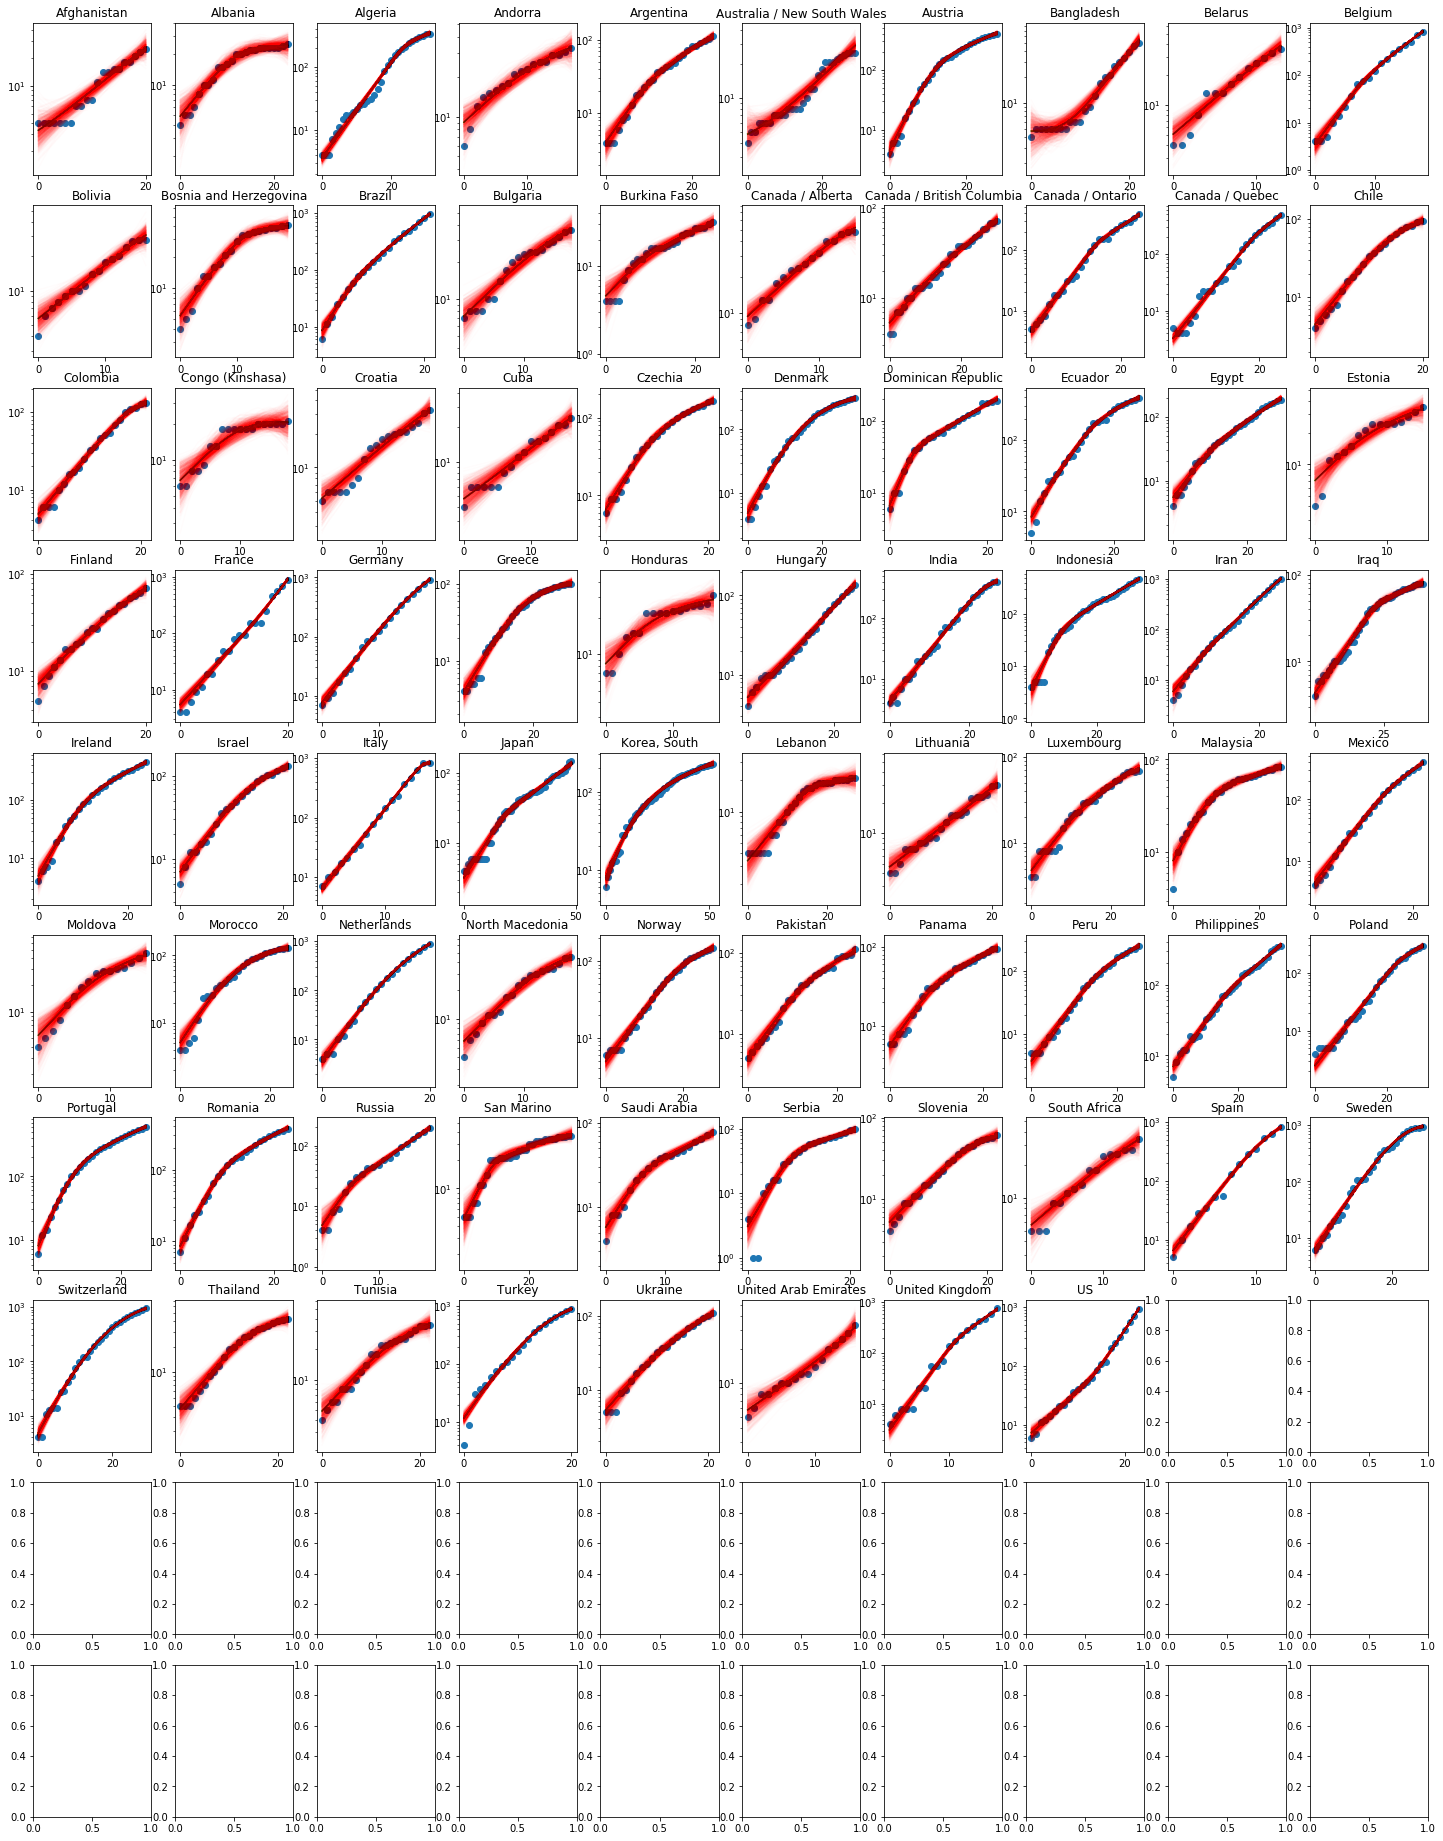

In [53]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(10, 10, figsize=(fig_scale*25,fig_scale*33))
a = ax.flatten()
for i, c in enumerate(deaths):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].plot(deaths[c], 'o')
    a[i].semilogy(np.mean(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                                     samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                                     samples['t0'][::10,i].T, t[:,None]), axis=1), 'g', alpha=1)
    a[i].plot(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                         samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                         samples['t0'][::10,i].T, t[:,None]), 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1.0_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

DeviceArray([ -0.7636235 ,   6.881309  ,  21.92165   ,  13.110588  ,
               6.10674   ,  37.184807  ,   4.97752   ,   5.7964435 ,
               8.234155  ,   5.4994903 ,  15.833773  ,   5.511345  ,
              -1.2493893 ,  19.729847  ,  12.06938   ,  13.832177  ,
              14.4889555 ,  12.666457  ,  17.355688  ,   7.8754106 ,
              13.307158  ,   7.350634  ,  18.94673   ,  13.025634  ,
               4.1556807 ,  -5.701153  ,   3.2360487 ,  -0.80227095,
               3.480781  ,   7.217173  ,   7.0927386 ,  16.141384  ,
               5.6246967 ,   4.7118926 ,   5.326549  ,  19.864199  ,
              20.200285  ,   5.77327   ,   4.658813  ,  19.15343   ,
               3.0146732 ,   5.6619015 ,  15.544807  ,  16.108252  ,
              -8.950559  ,  11.866864  ,  19.88431   ,  14.289277  ,
               5.0846677 ,  10.031555  ,   6.052905  ,  -1.3793318 ,
               3.125802  ,  10.287123  ,  15.161152  ,   7.762488  ,
               5.2428217 ,  10.609

(0, 35)

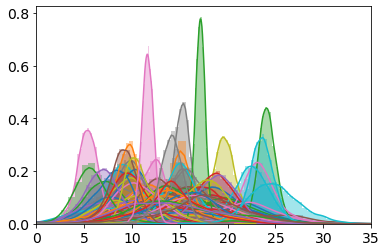

In [31]:
for i, c in enumerate(deaths):
    sns.distplot(samples['t0'][:,i])
plt.xlim(0, 35)

(0.8, 2)

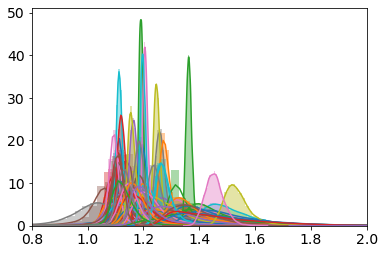

In [28]:
for i, c in enumerate(deaths):
    sns.distplot(samples['GR1'][:,i])
plt.xlim(0.8, 1.8)

(0.8, 1.5)

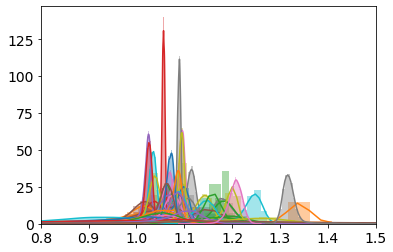

In [30]:
for i, c in enumerate(deaths):
    sns.distplot(samples['GR2'][:,i])
plt.xlim(0.8, 1.5)

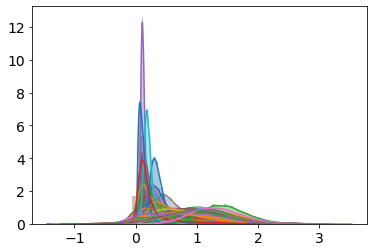

In [48]:
for i, c in enumerate(deaths):
    sns.distplot(samples['Decay'][:,i])
# plt.xlim(0.8, 1.5)

# Trace Plots

Text(0, 0.5, 'Growth Rate')

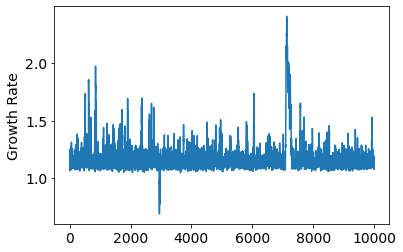

In [49]:
plt.plot(samples['GR1'][:,1])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Growth Rate')

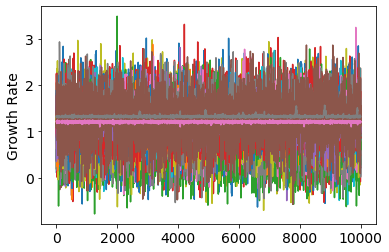

In [34]:
plt.plot(samples['GR2'])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Time of intervention')

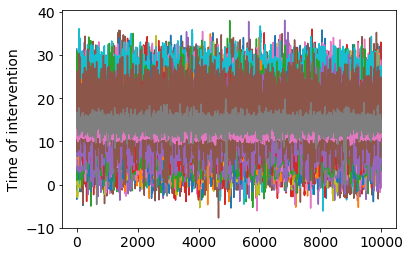

In [35]:
plt.plot(samples['t0'])
plt.ylabel('Time of intervention')

Text(0, 0.5, 'Initial Deaths')

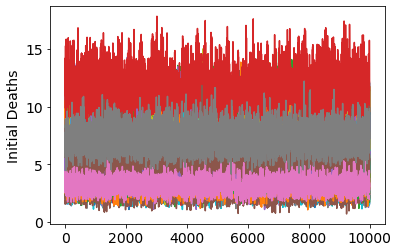

In [33]:
plt.plot(samples['Di'])
plt.ylabel('Initial Deaths')

Text(0, 0.5, 'Decay Time')

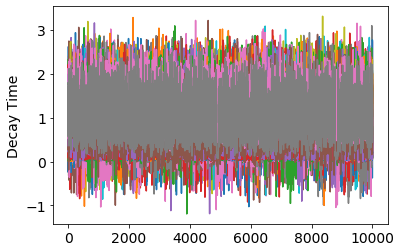

In [37]:
plt.plot(samples['Decay'])
plt.ylabel('Decay Time')